In [125]:
import discord
import random
import os
import asyncio

import pandas as pd
import requests

In [126]:
#########################

In [127]:
import pandas as pd
import glob
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [128]:
import pandas as pd
import numpy as np

def func_1(df):
    # Drop duplicates early on
    df = df.drop_duplicates()

    # Columns to replace NaNs
    df[['wides', 'noballs', 'byes', 'legbyes']] = df[['wides', 'noballs', 'byes', 'legbyes']].fillna(0)
    df[['wicket_type', 'player_dismissed']] = df[['wicket_type', 'player_dismissed']].fillna('')

    # Convert columns to string type where required
    cols_to_string = ['batting_team', 'bowling_team', 'striker', 'non_striker', 'bowler', 'wicket_type', 'player_dismissed']
    df[cols_to_string] = df[cols_to_string].astype(str)

    # Sort once for ease of cumulative calculations
    df = df.sort_values(by=['start_date', 'match_id', 'innings', 'ball']).reset_index(drop=True)

    # Calculate legality and bowler wicket conditions
    df['legality'] = (df['wides'] + df['noballs']) == 0
    df['bowler_wicket'] = df['wicket_type'].isin(['caught', 'bowled', 'lbw', 'stumped', 'caught and bowled', 'hit wicket', 'out'])

    # Flagging and categorizing runs
    df['islegal'] = df['legality'].astype(int)
    df['isDotforBatter'] = (df['runs_off_bat'] == 0).astype(int)
    df['isOne'] = (df['runs_off_bat'] == 1).astype(int)
    df['isTwo'] = (df['runs_off_bat'] == 2).astype(int)
    df['isThree'] = (df['runs_off_bat'] == 3).astype(int)
    df['isStrikeRotation'] = df['runs_off_bat'].isin([1, 2, 3, 5, 7]).astype(int)
    df['isFour'] = (df['runs_off_bat'] == 4).astype(int)
    df['isSix'] = (df['runs_off_bat'] == 6).astype(int)
    df['isBowlerWicket'] = df['bowler_wicket'].astype(int)
    df['is_striker_Out'] = (df['striker'] == df['player_dismissed']).astype(int)
    df['is_nonstriker_Out'] = (df['non_striker'] == df['player_dismissed']).astype(int)
    df['isWicket'] = (df['wicket_type'] != '').astype(int)
    df['total_runs'] = df['runs_off_bat'] + df['extras']
    
    # Convert relevant columns to numeric
    df['total_runs'] = pd.to_numeric(df['total_runs'], errors='coerce')
    df['isWicket'] = pd.to_numeric(df['isWicket'], errors='coerce')
    df['islegal'] = pd.to_numeric(df['islegal'], errors='coerce')

    # Fill any NaNs generated due to coercion with 0 (if appropriate for your logic)
    df['total_runs'].fillna(0, inplace=True)
    df['isWicket'].fillna(0, inplace=True)
    df['islegal'].fillna(0, inplace=True)

    # Cumulative sums for runs and wickets
    df['runs_scored'] = df.groupby(['match_id', 'innings'])['total_runs'].cumsum()
    df['wickets_down'] = df.groupby(['match_id', 'innings'])['isWicket'].cumsum()
    df['legal_balls_bowled'] = df.groupby(['match_id', 'innings'])['islegal'].cumsum()
    
    # Calculate run rate and target
    df['run_rate'] = df.apply(lambda x: (6 * x['runs_scored'] / x['legal_balls_bowled']) 
                              if x['legal_balls_bowled'] > 0 else 6 + x['runs_scored'], axis=1)
    

    # Calculate partnership runs with forward filling of last fall of wicket (fow) information
    df['last_fow'] = df['runs_scored'].where(df['isWicket'] == 1).ffill().fillna(0)
    df['partnership_runs'] = df['runs_scored'] - df['last_fow']

    # Calculate cumulative balls faced by each striker and non-striker
    df['isno'] = df['noballs'] > 0
    df['is_faced_by_batter'] = (df['islegal'] | df['isno']).astype(int)

    # Cumulative balls and runs for striker and non-striker
    striker_runs = []
    non_striker_runs = []
    striker_balls = []
    non_striker_balls = []
    
    
    # Calculate last fall of wicket (fow) run rate
    df['last_fow_run_rate'] = df.groupby(['match_id', 'innings'])['run_rate'].apply(lambda x: x.where(df['isWicket'] == 1).ffill())
    df.reset_index(drop=True, inplace=True)

    return df


In [129]:
def func_2(df_1):


    #### creation of fours_hit, sixes_hit

    # Sort the DataFrame by 'match_id', 'innings' for forward filling
    df_1.sort_values(by=['match_id', 'start_date', 'innings', 'ball'], inplace=True)

    # Group by 'match_id' and 'innings' and forward-fill NaN values within each group
    df_1['fours'] = df_1.groupby(['match_id', 'innings'])['isFour'].cumsum()
    df_1['sixes'] = df_1.groupby(['match_id', 'innings'])['isSix'].cumsum()

    # Reset the DataFrame index
    df_1.reset_index(drop=True, inplace=True)

    # Initialize a dictionary to store player-to-number mappings for each match_id
    player_to_number = {}

    # Initialize a list to store player_number
    player_number = [1]

    # Function to update player-to-number mappings
    def update_player_mapping(player):
        player_to_number[player] = player_number[0]
        player_number[0] += 1

    # Lists to store batting positions for striker and non-striker
    striker_positions = []
    non_striker_positions = []

    # Initialize current match_id
    current_match_id = None

    # Iterate through DataFrame rows
    for index, row in df_1.iterrows():
        #print(index)

        match_id = row['match_id']
        striker = row['striker']
        non_striker = row['non_striker']

        # Check if it's a new match_id
        if current_match_id != match_id:
            current_match_id = match_id
            player_to_number.clear()
            player_number[0] = 1

        # Check if striker has been encountered before in this match
        if striker not in player_to_number:
            update_player_mapping(striker)

        # Check if non-striker has been encountered before in this match
        if non_striker not in player_to_number:
            update_player_mapping(non_striker)

        # Append player numbers to the respective lists
        striker_positions.append(player_to_number[striker])
        non_striker_positions.append(player_to_number[non_striker])

    # Create new columns 'striker_batting_position' and 'non_striker_batting_position'
    df_1['striker_batting_position'] = striker_positions
    df_1['non_striker_batting_position'] = non_striker_positions


    return df_1

In [130]:
#ground stats
df_g = pd.read_csv('/Users/roumyadas/Desktop/Data/t20_cricket_data/Data/created_data/ground_stats.csv')

#bowler stats
df_bo_1 = pd.read_csv('/Users/roumyadas/Desktop/Data/t20_cricket_data/Data/created_data/bowler_stats_inn1.csv')
df_bo_2 = pd.read_csv('/Users/roumyadas/Desktop/Data/t20_cricket_data/Data/created_data/bowler_stats_inn2.csv')

df_bo = pd.concat([df_bo_1,df_bo_2], axis=0)
df_bo.reset_index(drop=True, inplace=True)

#batter stats
df_ba_1 = pd.read_csv('/Users/roumyadas/Desktop/Data/t20_cricket_data/Data/created_data/batter_stats_inn1.csv')
df_ba_2 = pd.read_csv('/Users/roumyadas/Desktop/Data/t20_cricket_data/Data/created_data/batter_stats_inn2.csv')

df_ba = pd.concat([df_ba_1,df_ba_2], axis=0)
df_ba.reset_index(drop=True, inplace=True)

#h2h factor
h2h = pd.read_csv('/Users/roumyadas/Desktop/Data/t20_cricket_data/Data/created_data/h2h_stats.csv')

#form factor-batter
form_ba_1 = pd.read_csv('/Users/roumyadas/Desktop/Data/t20_cricket_data/Data/created_data/batter_stats_form_inn1.csv')
form_ba_2 = pd.read_csv('/Users/roumyadas/Desktop/Data/t20_cricket_data/Data/created_data/batter_stats_form_inn2.csv')

form_ba = pd.concat([form_ba_1,form_ba_2], axis=0)
form_ba.reset_index(drop=True, inplace=True)

#form factor-bowler
form_bo_1 = pd.read_csv('/Users/roumyadas/Desktop/Data/t20_cricket_data/Data/created_data/bowler_stats_form_inn1.csv')
form_bo_2 = pd.read_csv('/Users/roumyadas/Desktop/Data/t20_cricket_data/Data/created_data/bowler_stats_form_inn2.csv')

form_bo = pd.concat([form_bo_1,form_bo_2], axis=0)
form_bo.reset_index(drop=True, inplace=True)

In [131]:
player_list = pd.read_excel('/Users/roumyadas/Desktop/Data/t20_cricket_data/Data/created_data/player_list.xlsx',
                           sheet_name='players_sets')

In [132]:
player_list

,Set,Name,Country,Specialism,Unnamed: 4,Func_Name,Unnamed: 6,Spin/Pace
0,R,Jasprit Bumrah,India,BOWLER,NaN,JJ Bumrah,NaN,Pace
1,R,SuryaKumar Yadav,India,BATTER,NaN,SA Yadav,NaN,0
2,R,Hardik Pandya,India,ALL-ROUNDER,NaN,HH Pandya,NaN,Pace
3,R,Rohit Sharma,India,BATTER,NaN,RG Sharma,NaN,0
4,R,Tilak Varma,India,BATTER,NaN,Tilak Varma,NaN,0
5,R,Ruturaj Gaikwad,India,BATTER,NaN,RD Gaikwad,NaN,0
6,R,Ravindra Jadeja,India,ALL-ROUNDER,NaN,RA Jadeja,NaN,Spin
7,R,Matheesha Pathirana,Sri Lanka,BOWLER,NaN,M Pathirana,NaN,Pace
8,R,Shivam Dube,India,ALL-ROUNDER,NaN,S Dube,NaN,Pace
9,R,MSD,India,WICKETKEEPER,NaN,MS Dhoni,NaN,0


In [133]:
def team_map(value):
    if value=='CSK':
        return team_CSK
    elif value=='DC':
        return team_DC
    elif value=='GT':
        return team_GT
    elif value=='KKR':
        return team_KKR
    elif value=='LSG':
        return team_LSG
    elif value=='MI':
        return team_MI
    elif value=='PBKS':
        return team_PBKS
    elif value=='RCB':
        return team_RCB
    elif value=='RR':
        return team_RR
    elif value=='SRH':
        return team_SRH
    else:
        return pd.DataFrame()

## run this cell if there's a change to the squad

In [134]:
team_CSK = pd.read_excel('/Users/roumyadas/Desktop/IPL_Simulation/Teams/SQUADS.xlsx', 
                        sheet_name='CSK')
team_CSK = team_CSK.sort_values(by='XI').head(11)
team_CSK = team_CSK.merge(player_list[['Name','Func_Name']], on='Name', how='left')
team_CSK['Func_Name'] = team_CSK['Func_Name'].fillna(team_CSK['Name'])

team_DC = pd.read_excel('/Users/roumyadas/Desktop/IPL_Simulation/Teams/SQUADS.xlsx', 
                        sheet_name='DC')
team_DC = team_DC.sort_values(by='XI').head(11)
team_DC  = team_DC.merge(player_list[['Name','Func_Name']], on='Name', how='left')
team_DC['Func_Name'] = team_DC['Func_Name'].fillna(team_DC['Name'])

team_GT = pd.read_excel('/Users/roumyadas/Desktop/IPL_Simulation/Teams/SQUADS.xlsx', 
                        sheet_name='GT')
team_GT = team_GT.sort_values(by='XI').head(11)
team_GT  = team_GT.merge(player_list[['Name','Func_Name']], on='Name', how='left')
team_GT['Func_Name'] = team_GT['Func_Name'].fillna(team_GT['Name'])

team_KKR = pd.read_excel('/Users/roumyadas/Desktop/IPL_Simulation/Teams/SQUADS.xlsx', 
                        sheet_name='KKR')
team_KKR = team_KKR.sort_values(by='XI').head(11)
team_KKR  = team_KKR.merge(player_list[['Name','Func_Name']], on='Name', how='left')
team_KKR['Func_Name'] = team_KKR['Func_Name'].fillna(team_KKR['Name'])

team_LSG = pd.read_excel('/Users/roumyadas/Desktop/IPL_Simulation/Teams/SQUADS.xlsx', 
                        sheet_name='LSG')
team_LSG = team_LSG.sort_values(by='XI').head(11)
team_LSG  = team_LSG.merge(player_list[['Name','Func_Name']], on='Name', how='left')
team_LSG['Func_Name'] = team_LSG['Func_Name'].fillna(team_LSG['Name'])

team_MI = pd.read_excel('/Users/roumyadas/Desktop/IPL_Simulation/Teams/SQUADS.xlsx', 
                        sheet_name='MI')
team_MI = team_MI.sort_values(by='XI').head(11)
team_MI  = team_MI.merge(player_list[['Name','Func_Name']], on='Name', how='left')
team_MI['Func_Name'] = team_MI['Func_Name'].fillna(team_MI['Name'])

team_PBKS = pd.read_excel('/Users/roumyadas/Desktop/IPL_Simulation/Teams/SQUADS.xlsx', 
                        sheet_name='PBKS')
team_PBKS = team_PBKS.sort_values(by='XI').head(11)
team_PBKS  = team_PBKS.merge(player_list[['Name','Func_Name']], on='Name', how='left')
team_PBKS['Func_Name'] = team_PBKS['Func_Name'].fillna(team_PBKS['Name'])

team_RCB = pd.read_excel('/Users/roumyadas/Desktop/IPL_Simulation/Teams/SQUADS.xlsx', 
                        sheet_name='RCB')
team_RCB = team_RCB.sort_values(by='XI').head(11)
team_RCB  = team_RCB.merge(player_list[['Name','Func_Name']], on='Name', how='left')
team_RCB['Func_Name'] = team_RCB['Func_Name'].fillna(team_RCB['Name'])

team_RR = pd.read_excel('/Users/roumyadas/Desktop/IPL_Simulation/Teams/SQUADS.xlsx', 
                        sheet_name='RR')
team_RR = team_RR.sort_values(by='XI').head(11)
team_RR  = team_RR.merge(player_list[['Name','Func_Name']], on='Name', how='left')
team_RR['Func_Name'] = team_RR['Func_Name'].fillna(team_RR['Name'])

team_SRH = pd.read_excel('/Users/roumyadas/Desktop/IPL_Simulation/Teams/SQUADS.xlsx', 
                        sheet_name='SRH')
team_SRH = team_SRH.sort_values(by='XI').head(11)
team_SRH  = team_SRH.merge(player_list[['Name','Func_Name']], on='Name', how='left')
team_SRH['Func_Name'] = team_SRH['Func_Name'].fillna(team_SRH['Name'])

team_SRH

In [135]:
from contextlib import redirect_stdout

df_all.sample(1)

In [136]:
def match_scorecard(match_id):
    # Specify the output file
    output_file = "/Users/roumyadas/Desktop/IPL_Simulation/Scorecards/matchcard_" + str(match_id) + ".txt"

    m_id = int(match_id.replace('M',''))
    # Redirect the output
    with open(output_file, "w") as f:
        with redirect_stdout(f):
            
            m_id = int(match_id.replace('M',''))
            teams = matches_list.iloc[m_id-1][1:].values[0], matches_list.iloc[m_id-1][1:].values[1]
            print(f"Match between {teams[0]}(H) and {teams[1]} !! ")
    
            ## bowler stats

            df_mod_1 = df_all[(df_all.match_id==match_id)&(df_all.innings==1)]
            df_mod_2 = df_all[(df_all.match_id==match_id)&(df_all.innings==2)]
            
            team1 = df_mod_1.batting_team.unique()[0]
            team2 = df_mod_2.batting_team.unique()[0]


            total_1 = df_mod_1['total_runs'].sum()
            total_2 = df_mod_2['total_runs'].sum()

            wickets_1 = df_mod_1['isWicket'].sum()
            wickets_2 = df_mod_2['isWicket'].sum()

            balls_1 = df_mod_1['legal_balls_bowled'].max()
            balls_2 = df_mod_2['legal_balls_bowled'].max()
            overs_1 = str(balls_1//6)+"."+str(balls_1%6)
            overs_2 = str(balls_2//6)+"."+str(balls_2%6)


            bowler_stats = df_mod_1.groupby(['bowler','bowling_team']).agg(   ##,'innings'
                runs = ('runs_conceeded','sum'),
                balls = ('islegal' ,'sum'),
                wkts = ('isBowlerWicket','sum'),
                dots = ('isDotforbowler','sum')

            ).reset_index()

            bowler_stats['economy'] = 6*bowler_stats['runs']/bowler_stats['balls']

            bowler_stats = bowler_stats.sort_values(['wkts','economy'], ascending=[False, True]).reset_index(drop=True)

            #batting stats

            batter_stats = df_mod_1.groupby(['striker','batting_team']).agg(  ##,'innings'
                runs = ('runs_off_bat','sum'),
                balls = ('is_faced_by_batter' ,'sum'),
                fours = ('isFour','sum'),
                sixes = ('isSix','sum'),
                out = ('is_striker_Out','sum'),
                dots = ('isDotforBatter','sum')

            ).reset_index()

            batter_stats['strike_rate'] = 100*batter_stats['runs']/batter_stats['balls']
            for index,row in batter_stats.iterrows():
                batter = row['striker']
                if (batter in df_mod_1.player_dismissed.unique())==True:

                    new_out_value = 1
                    batter_stats.at[index, 'out'] = new_out_value

            batter_stats['out'] = batter_stats['out'].replace(0,'**')
            batter_stats['out'] = batter_stats['out'].replace(1,'out')

            batter_stats = batter_stats.sort_values(['runs','strike_rate'], ascending=[False,False]).reset_index(drop=True)

            batter_stats = batter_stats.round(2)
            bowler_stats = bowler_stats.round(2)
            
            batter_stats['points'] = 0
            bowler_stats['points'] = 0
            
            for index, row in batter_stats.iterrows():
                #batting
                run_pt = row['runs']*1
                bdry_pt = row['fours']*1+row['sixes']*2
                dot_pt = row['dots']*(-0.25)

                sr_pt = 6 if row['strike_rate']>=170 else 4 if row['strike_rate']>150 else 2 if row['strike_rate']>130 else \
                        0 if row['strike_rate']>70 else -2 if row['strike_rate']>=60 else -4 if row['strike_rate']>=50 else -6

                milestone_pt = 16 if row['runs']>=100 else 8 if row['runs']>=50 else 4 if row['runs']>=30 else 0

                total_pt = run_pt+bdry_pt+dot_pt+sr_pt+milestone_pt
                
                batter_stats.at[index, 'points'] = total_pt
                
            for index, row in bowler_stats.iterrows():
                #bowling
                wkt_pt = row['wkts']*25
                wkt_bonus_pt = (16 if row['wkts']>=5 else 8 if row['wkts']>=4 else 4 if row['wkts']>=3 else 0)
                dot_pt = row['dots']*0.25

                eco_pt = -6 if row['economy']>12 else -4 if row['economy']>11 else -2 if row['economy']>=10 else \
                          0 if row['economy']>7 else 2 if row['economy']>=6 else 4 if row['economy']>=5 else 6 

                total_pt = wkt_pt+wkt_bonus_pt+dot_pt+eco_pt
                
                bowler_stats.at[index, 'points'] = total_pt
                
                
            ######## points dictionary
            bat_pt = batter_stats[['striker','points']].rename(columns={'striker':'player','points':'points1'})
            bowl_pt = bowler_stats[['bowler','points']].rename(columns={'bowler':'player','points':'points1'})
            pt1 = pd.concat([bat_pt,bowl_pt],axis=0)
            
            
            

            print("innings 1")
            
            print(f"{team2} BOWLING ---")
            print("^^"*10)
            print(bowler_stats)
            print("--"*5)
            print(f"{team1} BATTING --")
            print("^^"*10)
            print(batter_stats.drop(['fours','sixes','dots'], axis=1))
            print("  ")
            print(f"Score :: {total_1}-{wickets_1}  ({overs_1}), run-rate = {np.round(6*total_1/balls_1, 2)}")
            print("***"*10)
            print("***"*10)

            
            
            bowler_stats = df_mod_2.groupby(['bowler','bowling_team']).agg(   ##,'innings'
                runs = ('runs_conceeded','sum'),
                balls = ('islegal' ,'sum'),
                wkts = ('isBowlerWicket','sum'),
                dots = ('isDotforbowler','sum')

            ).reset_index()

            bowler_stats['economy'] = 6*bowler_stats['runs']/bowler_stats['balls']

            bowler_stats = bowler_stats.sort_values(['wkts','economy'], ascending=[False, True]).reset_index(drop=True)

            #batting stats

            batter_stats = df_mod_2.groupby(['striker','batting_team']).agg(  ##,'innings'
                runs = ('runs_off_bat','sum'),
                balls = ('is_faced_by_batter' ,'sum'),
                fours = ('isFour','sum'),
                sixes = ('isSix','sum'),
                outs = ('is_striker_Out','sum'),
                dots = ('isDotforBatter','sum')

            ).reset_index()

            batter_stats['strike_rate'] = 100*batter_stats['runs']/batter_stats['balls']
            for index,row in batter_stats.iterrows():
                batter = row['striker']
                if batter in df_mod_2.player_dismissed.unique():
                    new_out_value = 1
                    batter_stats.at[index, 'outs'] = new_out_value

            batter_stats['outs'] = batter_stats['outs'].replace(0,'**')
            batter_stats['outs'] = batter_stats['outs'].replace(1,'out')

            batter_stats = batter_stats.sort_values(['runs','strike_rate'], ascending=[False,False]).reset_index(drop=True)

            batter_stats = batter_stats.round(2)
            bowler_stats = bowler_stats.round(2)


            winner = str(team1)+' wins!!' if total_1>total_2 else str(team2)+ ' wins!!' if total_1<total_2\
                                                    else "it's a TIE!!!!"
            
            
            
            batter_stats['points'] = 0
            bowler_stats['points'] = 0
            
            for index, row in batter_stats.iterrows():
                #batting
                run_pt = row['runs']*1
                bdry_pt = row['fours']*1+row['sixes']*2
                dot_pt = row['dots']*(-0.25)

                sr_pt = 6 if row['strike_rate']>=170 else 4 if row['strike_rate']>150 else 2 if row['strike_rate']>130 else \
                        0 if row['strike_rate']>70 else -2 if row['strike_rate']>=60 else -4 if row['strike_rate']>=50 else -6

                milestone_pt = 16 if row['runs']>=100 else 8 if row['runs']>=50 else 4 if row['runs']>=30 else 0

                total_pt = run_pt+bdry_pt+dot_pt+sr_pt+milestone_pt
                
                batter_stats.at[index, 'points'] = total_pt
                
            for index, row in bowler_stats.iterrows():
                #bowling
                wkt_pt = row['wkts']*25
                wkt_bonus_pt = (16 if row['wkts']>=5 else 8 if row['wkts']>=4 else 4 if row['wkts']>=3 else 0)
                dot_pt = row['dots']*0.25

                eco_pt = -6 if row['economy']>12 else -4 if row['economy']>11 else -2 if row['economy']>=10 else \
                          0 if row['economy']>7 else 2 if row['economy']>=6 else 4 if row['economy']>=5 else 6 

                total_pt = wkt_pt+wkt_bonus_pt+dot_pt+eco_pt
                
                bowler_stats.at[index, 'points'] = total_pt

            
            ######## points dictionary
            bat_pt = batter_stats[['striker','points']].rename(columns={'striker':'player','points':'points2'})
            bowl_pt = bowler_stats[['bowler','points']].rename(columns={'bowler':'player','points':'points2'})
            pt2 = pd.concat([bat_pt,bowl_pt],axis=0)
            
            
            pts = pt1.merge(pt2, on='player', how='outer')
            pts.fillna(0, inplace=True)
            pts['points'] = pts['points1']+pts['points2']
            pts.sort_values(by='points', ascending=False, inplace=True)
            
            top_point = pts.head(1).player.unique()[0]
            

            print("innings 2")
            
            print(f"{team1} BOWLING ---")
            print("^^"*10)
            print(bowler_stats)
            print("--"*5)
            print(f"{team2} BATTING --")
            print("^^"*10)
            print(batter_stats.drop(['fours','sixes','dots'], axis=1))
            print("  ")
            print(f"Score :: {total_2}-{wickets_2}  ({overs_2}), run-rate = {np.round(6*total_2/balls_2, 2)}")
            print("***"*10)
            print("***"*10)
            print(f"{winner}")
            print("***"*10)
            print(f"The Player of the Match is ~~ {top_point}")
        
    print(f"All output has been saved to {output_file}")


In [137]:
import time as time

t1 = time.time()

import random
from datetime import datetime, timedelta

# Define the teams
teams = ["CSK", "DC", "GT","KKR","LSG","MI","PBKS","RCB","RR","SRH"]


## run this before playoffs

In [138]:
matches_list = pd.read_excel('/Users/roumyadas/Desktop/IPL_Simulation/Fixtures/IPL_2024_schedule.xlsx',
                            sheet_name='mod')

matches_list = matches_list[['Date','Team One','Team Two']]

In [139]:
df_all = pd.DataFrame()

In [140]:
#g = random.choice(range(10,90))
g = 50
ground_factor =  (g/(100-g))   ##(25/75)  #Spin/Pace

df_all = df_all[~(df_all.match_id=='M074')]

for m in range(0,10):

    match_number = m
    with open('run_match_mod.py') as f:
        exec(f.read())

In [141]:
%%time
from IPython.display import clear_output

m=0 
for m in range(70): 
    #g = random.choice(range(10,90))
    #ground_factor =  (g/(100-g))
    #print(ground_factor)

    match_number = m
    success = False 
    clear_output(wait=True)

    while not success:  
        try:

            with open('run_match_mod.py') as f:
                exec(f.read())
            success = True
            print(f"Match {match_number} executed successfully!")

        except Exception as e:
            # Handle the error and retry
            print(f"Error in match {match_number}: {e}")
            print("Retrying...")


Error in match 69: division by zero
Retrying...
Error in match 69: division by zero
Retrying...
All output has been saved to /Users/roumyadas/Desktop/IPL_Simulation/Match_flows/ball-by-ball_70.txt
Match 69 executed successfully!
CPU times: user 3min 37s, sys: 2.32 s, total: 3min 39s
Wall time: 3min 37s


In [142]:
print("Match Scorecard")
from IPython.display import clear_output
for m_id in df_all.match_id.unique():
    clear_output(wait=True)
    print("--")
    #m_id = 'M074'
    #for m_id in df_all.match_id.unique():
    #for m_id in ['M074']:
    match_scorecard(m_id)
    #'M001'

--
All output has been saved to /Users/roumyadas/Desktop/IPL_Simulation/Scorecards/matchcard_M070.txt


In [143]:
df_all.to_csv('/Users/roumyadas/Desktop/IPL_Simulation/df_all_round_sim_old.csv', index=None)

df_all.match_id.unique()

import pandas as pd
import requests
from io import BytesIO

shareable_link = "https://my.microsoftpersonalcontent.com/personal/c7f816dd80200c06/_layouts/15/download.aspx?UniqueId=607cbf6a-4a49-4a79-b5bc-a893932a6817&Translate=false&tempauth=v1e.eyJzaXRlaWQiOiJkNmQ3YThiOS00MWU2LTRjYzQtYjI1My1mOTZjMmFlOGZiZDEiLCJhcHBpZCI6IjAwMDAwMDAwLTAwMDAtMDAwMC0wMDAwLTAwMDA0ODE3MTBhNCIsImF1ZCI6IjAwMDAwMDAzLTAwMDAtMGZmMS1jZTAwLTAwMDAwMDAwMDAwMC9teS5taWNyb3NvZnRwZXJzb25hbGNvbnRlbnQuY29tQDkxODgwNDBkLTZjNjctNGM1Yi1iMTEyLTM2YTMwNGI2NmRhZCIsImV4cCI6IjE3MzQxNDE4ODIifQ.1TOTcJE0vy6B631DYzO_Ja0mO0JvFkavFmPlH_FXloxVxO8ubho1eWFGBx_o3GZpHq9kQAuUYtXF4UoiE6qvb-WzPCwAsxeyaHEO4d8R__nUFR_ZAcFNXGPDTWzUM02xPf1-pwK74Ms7MYvozDE58VlSaE7QIFUgfex64Tu04M5RU8H9rPuKvq2GH1gEzZbrxQ_lvNlW1shVUvganlxVRtpztmG7hserH56saQ0dLLKsFL6b83IuAaXdMi3mKYlasZdZU4CFpa-Daq3QJQrorPEjzpphGwWhPiAj2gPGZMkB_GgfeaufnxX4CQjY7oIfXkshS0Likkp_fX7ZkNbYvwzp1UvuI2aU5dPru1fDpGoJJNkwiF2xgaSZigi24XTUT8kLnNlBdAjNNvo96eLRkw.r25inBxZNgwGisNVhNnhkL0e9fu_hp1gmfvg2F_Zedc&ApiVersion=2.0&AVOverride=1"

if "onedrive" in shareable_link:
    download_link = shareable_link.replace("redir?", "download?")
else:
    download_link = shareable_link

response = requests.get(download_link)
response.raise_for_status()  

with BytesIO(response.content) as file_stream:
    schedule = pd.read_excel(file_stream, engine='openpyxl', sheet_name="schedule")  
    batter_df = pd.read_excel(file_stream, engine='openpyxl', sheet_name="batter_stats")
    bowler_df = pd.read_excel(file_stream, engine='openpyxl', sheet_name="bowler_stats")
    pts_table = pd.read_excel(file_stream, engine='openpyxl', sheet_name="points_table")
    



pts_table

batter_df

In [112]:
print("-----"*300)

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [144]:
print('POINTS TABLE :::')


new_order = ["team", "matches_played", "points", "NRR"]
pts_table[new_order]
#.head(5)

POINTS TABLE :::


,team,matches_played,points,NRR
0,RR,14,18,0.760947
1,KKR,14,18,0.639185
2,PBKS,14,18,0.207227
3,RCB,14,18,0.015020
4,SRH,14,14,0.109365
5,LSG,14,14,-0.204453
6,GT,14,14,-0.567459
7,DC,14,12,0.198644
8,MI,14,8,-0.369123
9,CSK,14,6,-0.778768


In [145]:
pts_table[new_order].to_csv('/Users/roumyadas/Desktop/IPL_Simulation/points_table.csv', index=None)

In [146]:
print('Top BATTERS :::')

bat_reqd = batter_stats.iloc[15*0:15*2,:]
bat_reqd.to_csv('/Users/roumyadas/Desktop/IPL_Simulation/batter_stats_30.csv', index=None)
#.head(15)

Top BATTERS :::


In [147]:
print('Top BOWLERS :::')

bowl_reqd = bowler_stats.drop(['ones','twos','threes','wides','noballs'],axis=1).iloc[15*0:15*2,:]
#bowler_stats.iloc[15*0:15*2,:]
bowl_reqd.to_csv('/Users/roumyadas/Desktop/IPL_Simulation/bowler_stats_30.csv', index=None)
#.head(15)

Top BOWLERS :::


In [148]:
bowler_stats[bowler_stats.bowler.str.contains('Bumrah')]

,bowler,bowling_team,num_innings,runs,balls,wkts,fours,sixes,dots,ones,twos,threes,wides,noballs,economy,strike_rate,bpb,dot_%
8,JJ Bumrah,MI,14,374,243,19,31,19,96,74,13,10,6,0,9.23,12.79,4.86,39.51


In [149]:
bowl_reqd

,bowler,bowling_team,num_innings,runs,balls,wkts,fours,sixes,dots,economy,strike_rate,bpb,dot_%
0,Mukesh Kumar,DC,14,495,310,30,53,18,120,9.58,10.33,4.37,38.71
1,Mohammad Ghazanfar,MI,14,437,250,30,39,19,86,10.49,8.33,4.31,34.40
2,BA Carse,SRH,14,550,248,28,32,34,63,13.31,8.86,3.76,25.40
3,HV Patel,SRH,14,550,300,23,44,28,89,11.00,13.04,4.17,29.67
4,Mohammed Shami,SRH,14,426,293,22,38,20,117,8.72,13.32,5.05,39.93
5,MA Starc,DC,14,459,285,20,43,19,105,9.66,14.25,4.60,36.84
6,VG Arora,KKR,14,525,318,20,67,12,98,9.91,15.90,4.03,30.82
7,MP Yadav,LSG,14,483,324,19,40,19,108,8.94,17.05,5.49,33.33
8,JJ Bumrah,MI,14,374,243,19,31,19,96,9.23,12.79,4.86,39.51
9,Harshit Rana,KKR,14,499,312,19,45,23,97,9.60,16.42,4.59,31.09


In [150]:
bat_reqd

,striker,batting_team,num_innings,runs,balls,outs,fours,sixes,dots,ones,twos,threes,strike_rate,balls_per_dismissal,bat_avg,bpb,dot_%
0,PD Salt,RCB,14,590,338,14,55,28,91,150,20,4,174.56,24.14,42.14,4.07,26.92
1,Shubman Gill,GT,14,552,375,15,60,14,128,155,23,9,147.20,25.00,36.80,5.07,34.13
2,MR Marsh,LSG,14,508,333,12,49,20,124,118,25,8,152.55,27.75,42.33,4.83,37.24
3,B Sai Sudharsan,GT,14,502,321,10,42,22,96,138,23,6,156.39,32.10,50.20,5.02,29.91
4,DP Conway,CSK,14,489,337,11,41,15,99,150,32,7,145.10,30.64,44.45,6.02,29.38
5,TM Head,SRH,14,478,281,14,54,15,72,119,22,3,170.11,20.07,34.14,4.07,25.62
6,SV Samson,RR,14,478,313,13,48,17,111,119,22,7,152.72,24.08,36.77,4.82,35.46
7,SA Yadav,MI,14,462,305,16,46,19,113,107,21,5,151.48,19.06,28.88,4.69,37.05
8,AM Rahane,KKR,14,460,270,14,45,15,70,110,25,10,170.37,19.29,32.86,4.50,25.93
9,VR Iyer,KKR,14,451,258,9,40,20,62,125,14,6,174.81,28.67,50.11,4.30,24.03


In [119]:
batter_stats.to_csv('/Users/roumyadas/Desktop/IPL_Simulation/batter_stats_test.csv', index=None)
bowler_stats.to_csv('/Users/roumyadas/Desktop/IPL_Simulation/bowler_stats_test.csv', index=None)

In [151]:
tm = 'SRH'

print(f"{tm} stats!!!")

SRH stats!!!


In [152]:
batter_stats[batter_stats.batting_team==tm]

,striker,batting_team,num_innings,runs,balls,outs,fours,sixes,dots,ones,twos,threes,strike_rate,balls_per_dismissal,bat_avg,bpb,dot_%
5,TM Head,SRH,14,478,281,14,54,15,72,119,22,3,170.11,20.07,34.14,4.07,25.62
15,Abhishek Sharma,SRH,14,398,242,12,42,15,77,91,17,5,164.46,20.17,33.17,4.25,31.82
33,Ishan Kishan,SRH,14,307,175,15,31,15,61,57,12,4,175.43,11.67,20.47,3.80,34.86
37,H Klaasen,SRH,13,285,212,11,20,12,79,85,15,6,134.43,19.27,25.91,6.62,37.26
44,Nithish Kumar Reddy,SRH,14,236,198,15,15,11,78,92,9,0,119.19,13.20,15.73,7.62,39.39
51,A Manohar,SRH,13,183,127,8,16,8,53,40,8,5,144.09,15.88,22.88,5.29,41.73
65,PJ Cummins,SRH,8,137,90,4,8,6,29,37,7,6,152.22,22.50,34.25,6.43,32.22
69,HV Patel,SRH,10,118,81,7,11,6,33,26,6,0,145.68,11.57,16.86,4.76,40.74
71,BA Carse,SRH,8,112,51,6,7,6,13,10,7,8,219.61,8.50,18.67,3.92,25.49
81,Mohammed Shami,SRH,7,77,36,4,4,5,10,9,2,6,213.89,9.00,19.25,4.00,27.78


In [153]:
bowler_stats[bowler_stats.bowling_team==tm]

,bowler,bowling_team,num_innings,runs,balls,wkts,fours,sixes,dots,ones,twos,threes,wides,noballs,economy,strike_rate,bpb,dot_%
2,BA Carse,SRH,14,550,248,28,32,34,63,51,39,29,2,0,13.31,8.86,3.76,25.40
3,HV Patel,SRH,14,550,300,23,44,28,89,97,23,19,6,0,11.00,13.04,4.17,29.67
4,Mohammed Shami,SRH,14,426,293,22,38,20,117,96,16,6,8,0,8.72,13.32,5.05,39.93
19,RD Chahar,SRH,14,425,279,16,41,14,95,99,19,11,6,1,9.14,17.44,5.07,34.05
40,PJ Cummins,SRH,14,423,286,11,49,11,104,97,19,6,7,1,8.87,26.00,4.77,36.36


## score-worm plotting

/var/folders/68/nlclwstn1zd28pll4j60q7zw0000gn/T/ipykernel_1738/2534046659.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  live_score = df_all[df_all.match_id==m_id][df_all.innings==1].reset_index(drop=True)
/var/folders/68/nlclwstn1zd28pll4j60q7zw0000gn/T/ipykernel_1738/2534046659.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_other = df_all[df_all.match_id==m_id][df_all.innings==2].reset_index(drop=True)


FIRST INNING SCORE:
RUNS: 183
WICKETS: 4
BALLS BOWLED: 120


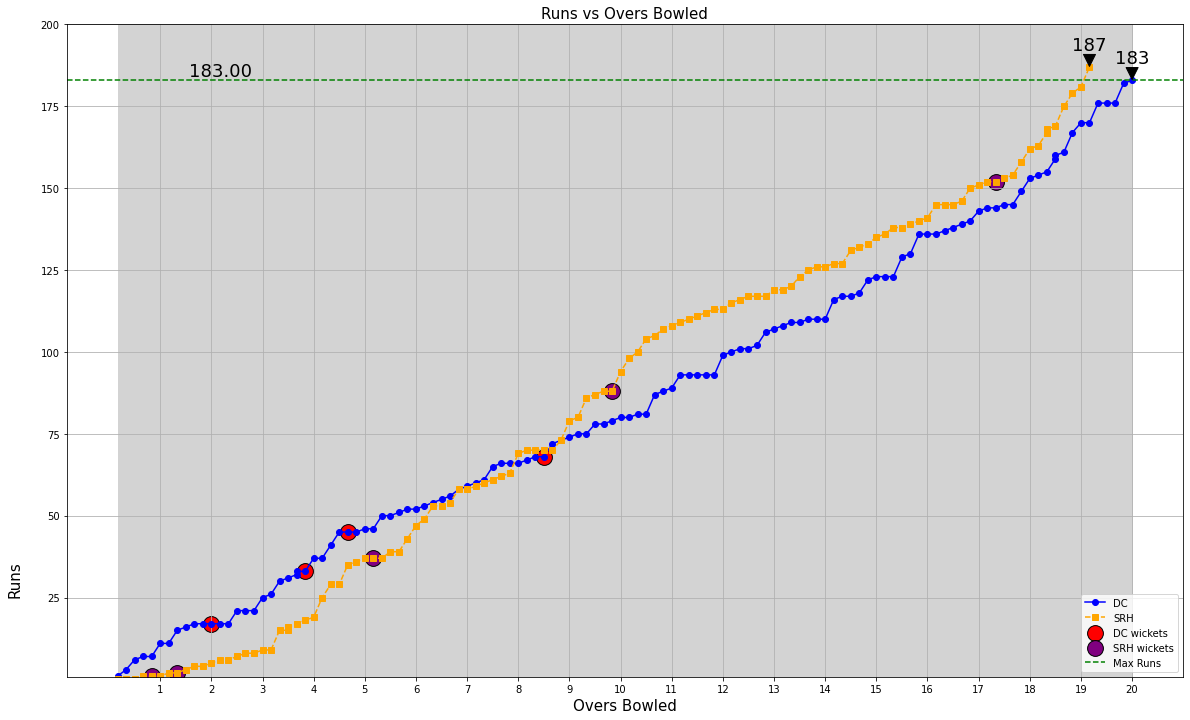

SECOND INNING SCORE:
RUNS: 187
WICKETS: 5
BALLS BOWLED: 115


In [165]:
m_id = 'M069'
live_score = df_all[df_all.match_id==m_id][df_all.innings==1].reset_index(drop=True)
df_other = df_all[df_all.match_id==m_id][df_all.innings==2].reset_index(drop=True)

bat_first = live_score['batting_team'].unique()[0]
bat_second = df_other['batting_team'].unique()[0]

print('FIRST INNING SCORE:')
print('RUNS:', live_score['runs_scored'].max())
print('WICKETS:', live_score['wickets_down'].max())
print('BALLS BOWLED:', live_score['legal_balls_bowled'].max())

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
# Assuming you have already imported your dataframe as 'live_score'

# Step 1: Remove duplicate rows based on 'predicted_runs' and 'legal_balls_bowled'
#live_score = live_score[live_score.legal_balls_bowled>=18]
live_score_unique = live_score.drop_duplicates(subset=['runs_scored', 'legal_balls_bowled'], keep='first')
df_other_unique = df_other.drop_duplicates(subset=['runs_scored', 'legal_balls_bowled'], keep='first')


#live_score_unique = live_score_unique[live_score_unique.legal_balls_bowled<=108]

# Calculate the minimum and maximum values for y-axis
min_y_limit = min(100, live_score_unique['runs_scored'].min() * 0.8)
max_y_limit = max(live_score_unique['runs_scored'].max() * 1.05, 200)

# Calculate the x-axis values by dividing 'legal_balls_bowled' by 6
x_values = live_score_unique['legal_balls_bowled'] / 6

# Calculate the x-axis values for the second line
x_values_other = df_other_unique['legal_balls_bowled'] / 6

# Plot the visualization
plt.figure(figsize=(20, 12))  # Set plot size to (15, 9)

# Add grey shade to background
plt.fill_between(x_values, 0, 250, color='lightgrey')

plt.plot(x_values, live_score_unique['runs_scored'], marker='o', linestyle='-', color='b', 
         label=bat_first)
# Plot the second line (df_other_unique)
plt.plot(x_values_other, df_other_unique['runs_scored'], marker='s', linestyle='--', color='orange', 
         label=bat_second)


# Add red dot for wicket
wicket_indices = live_score_unique[live_score_unique['isWicket'] == 1].index
plt.scatter(x_values[wicket_indices], 
            live_score_unique.loc[wicket_indices, 'runs_scored'], 
            color='r', s=250, marker='o', edgecolors='black', label=str(bat_first)+' wickets')

# Adding wicket markers for the second line
wicket_indices_other = df_other_unique[df_other_unique['isWicket'] == 1].index
plt.scatter(x_values_other[wicket_indices_other], 
            df_other_unique.loc[wicket_indices_other, 'runs_scored'], 
            color='purple', s=250, marker='o', edgecolors='black', label=str(bat_second)+' wickets')

# Annotate the last data point of the second line
last_index_other = df_other_unique.index[-1]
last_x_other = x_values_other.iloc[-1]
last_y_other = np.round(df_other_unique['runs_scored'].iloc[-1], 2)
plt.annotate(f'{last_y_other}', xy=(last_x_other, last_y_other), xytext=(last_x_other, last_y_other + 5), fontsize=18,
             arrowprops=dict(facecolor='black', shrink=0.05), xycoords='data', ha='center')


plt.ylim(min_y_limit, max_y_limit)  # Set y-axis range
plt.title('Runs vs Overs Bowled', fontsize=15)  # Updated title
plt.xlabel('Overs Bowled',  fontsize=15)  # Updated x-axis label
plt.ylabel('Runs', va='bottom',  fontsize=15)  # Updated y-axis label
plt.grid(True)

# Set x-axis ticks to display only integer values
plt.xticks(x_values[x_values.apply(lambda x: x.is_integer())])

# Annotate the last data point with its y-axis value just above the end of the line
last_index = live_score_unique.index[-1]
last_x = x_values.iloc[-1]
last_y = np.round(live_score_unique['runs_scored'].iloc[-1], 2)
plt.annotate(f'{last_y}', xy=(last_x, last_y), xytext=(last_x, last_y + 5), fontsize=18,
             arrowprops=dict(facecolor='black', shrink=0.05), xycoords='data', ha='center')

# Plot reference lines for highest and lowest predicted runs achieved
plt.axhline(y=live_score_unique['runs_scored'].max(), color='g', linestyle='--', label='Max Runs')

# Annotate the values of the reference lines on the y-axis
plt.text(2.8, live_score_unique['runs_scored'].max(), f'{live_score_unique["runs_scored"].max():.2f}',  va='bottom', ha='right', fontsize=18)#
#plt.text(2.8, live_score_unique['runs_scored'].min(), f'{live_score_unique["runs_scored"].min():.2f}',  va='top', ha='right', fontsize=18) #

plt.legend()  # Show legend

# Adjust the position of y-label to the bottom
plt.gca().yaxis.set_label_coords( -0.04, 0.15)

plt.show()

print('SECOND INNING SCORE:')
print('RUNS:', df_other['runs_scored'].max())
print('WICKETS:', df_other['wickets_down'].max())
print('BALLS BOWLED:', df_other['legal_balls_bowled'].max())